In [28]:
# cd /jet/home/bermudez
# interact -p GPU-shared --gres=gpu:1 -t 08:00:00 -A cis250242p
# module load AI/pytorch_23.02-1.13.1-py3
# conda activate eeg_env
# jupyter notebook --no-browser --ip=0.0.0.0

In [ ]:
# %%
config = {
    'root': "/ocean/projects/cis250019p/gandotra/11785-gp-eeg/ds005589",
    'captions': "/ocean/projects/cis250019p/gandotra/11785-gp-eeg/captions.txt",
    
    'batch_size': 128,
    
    'num_epochs': 100,
    'model_to_use': "Conformer", #Multihead|Multiscale|Conformer
    
    'num_channels':122,
    'num_classes':20,

    'hidden_dim':256,          

    'transformer_dim':384,    
    'n_layers':8,
    'n_heads':6,
    'ff_mult':4,

    'dropout':0.35,

    'lr': 2e-4,
    'weight_decay': 5e-4,
    'label_smoothing': 0.1,
    'max_grad_norm': 1.0,
    
    'results_path': "results/Conformer_Finetune_Multihead",
}

        

# Imports

In [3]:
# %%
import sys
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

from torchinfo import summary
import torch.optim as optim
import torch.nn as nn



from sklearn.metrics import (
    accuracy_score, confusion_matrix,
    precision_recall_fscore_support
)

# Add project path
import os
os.chdir('/jet/home/bermudez/exploring-eeg/4-eeg-classifiers')

# ---- Import modules from .py files ----
from data_extraction.dataset_builder import build_trial_index, split_by_session
from data_extraction.dataloader import make_dataloaders, eeg_collate_fn
from models.eeg_net_bl import EEGNetBL
from models.eeg_multihead_transformer import MultiHeadEEGClassifier
from utils.train_utils import (
    train_model, 
    train_multihead_model
)
from utils.eeg_embeddings import export_all_splits_multihead
from utils.eval_results import (
    evaluate_model,
    collect_predictions,
    plot_confusion_matrix,
    compute_per_class_accuracy,
    compute_global_metrics,
    metrics_to_dataframe,
    top_confusion_pairs
)
from models.eeg_multiscale_transformer import MultiScaleEEGTransformerMH
from models.eeg_conformer_multiscale import ConformerMultiScaleEEG


Device: cuda


In [4]:
save_dir = Path(config['results_path'])
save_dir.mkdir(exist_ok=True, parents=True)

# Dataset

In [5]:
# %%
DATASET_ROOT = Path(config['root'])
CAPTIONS_PATH = Path(config['captions'])

index_df = build_trial_index(DATASET_ROOT, CAPTIONS_PATH)
index_df = split_by_session(index_df)

print(index_df.head())
print("Total labeled trials:", len(index_df))

Found 519 EEG run files under /ocean/projects/cis250019p/gandotra/11785-gp-eeg/ds005589
Indexed 26000 EEG trials from 519 runs.
Loaded 9825 caption entries from captions.txt
Merged 9825 labels from captions.txt.
Filtered labeled EEG trials: 26000/26000 remain (100.0%)
Split summary:
split
train    15600
test      5200
val       5200
Name: count, dtype: int64
  subject session     run  trial  \
0  sub-02  ses-01  run-01      0   
1  sub-02  ses-01  run-01      1   
2  sub-02  ses-01  run-01      2   
3  sub-02  ses-01  run-01      3   
4  sub-02  ses-01  run-01      4   

                                            eeg_path  \
0  /ocean/projects/cis250019p/gandotra/11785-gp-e...   
1  /ocean/projects/cis250019p/gandotra/11785-gp-e...   
2  /ocean/projects/cis250019p/gandotra/11785-gp-e...   
3  /ocean/projects/cis250019p/gandotra/11785-gp-e...   
4  /ocean/projects/cis250019p/gandotra/11785-gp-e...   

                                            csv_path  \
0  /ocean/projects/cis250019p

# Dataloader

In [6]:
# %%
loaders = make_dataloaders(index_df,
                           batch_size=config['batch_size'],
                           num_workers=4)

# Inspect one batch
x_batch, y_batch = next(iter(loaders["train"]))
print("Batch EEG shape:", x_batch.shape)
print("Batch labels:", y_batch["class_id"][:10])

train: 15600 samples
val: 5200 samples
test: 5200 samples
Batch EEG shape: torch.Size([128, 500, 122])
Batch labels: tensor([16,  9, 11,  4, 13, 12, 15, 17,  7,  8])


# Data Visualization

In [7]:
# %%
def plot_eeg_trial(x, title="EEG Trial", n_channels_to_plot=6, sampling_rate=1000):
    if not isinstance(x, np.ndarray):
        x = x.detach().cpu().numpy()

    # ensure [C, T] shape
    if x.shape[0] > x.shape[1]:
        x = x.T

    num_channels, num_timepoints = x.shape
    time = np.arange(num_timepoints) / sampling_rate
    step = max(1, num_channels // n_channels_to_plot)

    plt.figure(figsize=(12, 6))
    for i, ch in enumerate(range(0, num_channels, step)):
        plt.plot(time, x[ch] + i * 5, lw=0.8)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (normalized)")
    plt.tight_layout()
    plt.show()

Subject: sub-15
Session: ses-05
Run: run-02
Category: chair


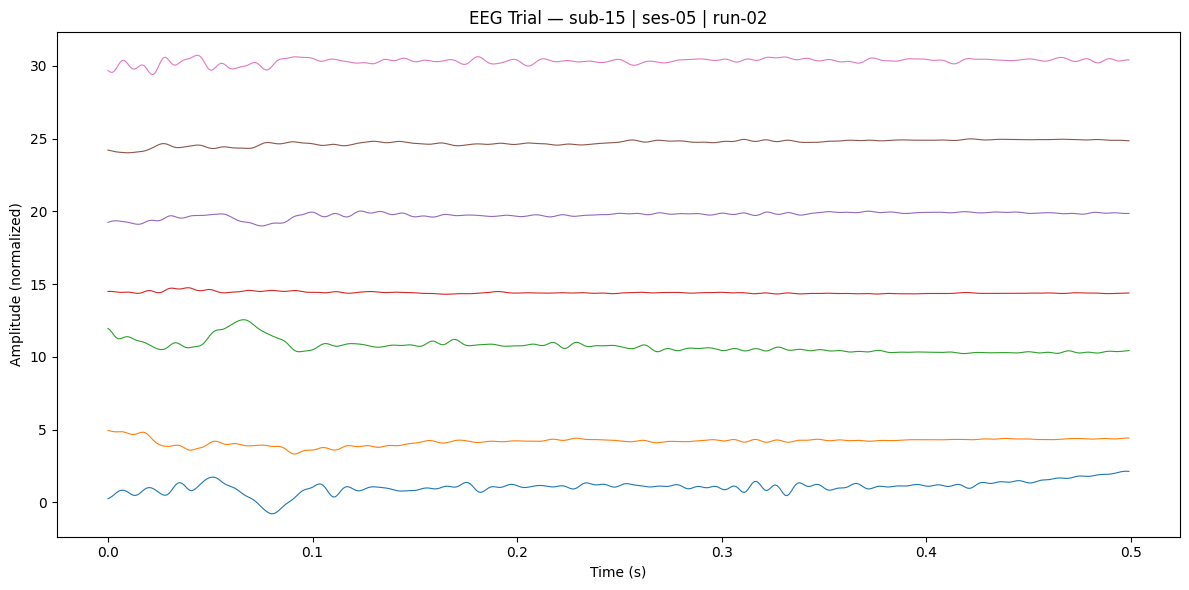

In [8]:
# %%
x_batch, y_batch = next(iter(loaders["train"]))

x_trial = x_batch[0]
meta = {k: v[0] for k, v in y_batch.items() if isinstance(v, list)}

print("Subject:", meta["subject"])
print("Session:", meta["session"])
print("Run:", meta["run"])
print("Category:", meta["category"])

plot_eeg_trial(x_trial, title=f"EEG Trial — {meta['subject']} | {meta['session']} | {meta['run']}")

# Base Line Model

## Setup

In [36]:
# %%
model = EEGNetBL(num_channels=122, num_classes=20).to(device)

print("Model loaded. Parameters:", sum(p.numel() for p in model.parameters()))

summary(
    model,
    input_size=(1, 122, 500),
    depth=4,
    col_names=["kernel_size", "output_size", "num_params"],
    verbose=0
)

Model loaded. Parameters: 63412
Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #
EEGNetBL                                 --                        [1, 20]                   --
├─Sequential: 1-1                        --                        [1, 8, 501]               --
│    └─Conv1d: 2-1                       [64]                      [1, 8, 501]               62,464
│    └─BatchNorm1d: 2-2                  --                        [1, 8, 501]               16
│    └─ELU: 2-3                          --                        [1, 8, 501]               --
├─Sequential: 1-2                        --                        [1, 16, 125]              --
│    └─Conv1d: 2-4                       [1]                       [1, 16, 501]              16
│    └─BatchNorm1d: 2-5                  --                        [1, 16, 501]              32
│    └─ELU: 2-6                          --                        [1, 16, 501]              --

Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #
EEGNetBL                                 --                        [1, 20]                   --
├─Sequential: 1-1                        --                        [1, 8, 501]               --
│    └─Conv1d: 2-1                       [64]                      [1, 8, 501]               62,464
│    └─BatchNorm1d: 2-2                  --                        [1, 8, 501]               16
│    └─ELU: 2-3                          --                        [1, 8, 501]               --
├─Sequential: 1-2                        --                        [1, 16, 125]              --
│    └─Conv1d: 2-4                       [1]                       [1, 16, 501]              16
│    └─BatchNorm1d: 2-5                  --                        [1, 16, 501]              32
│    └─ELU: 2-6                          --                        [1, 16, 501]              --
│    └─AvgPool1d: 2-7          

In [37]:
# %%
EPOCHS = config["num_epochs"]
LR = 3e-4

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

print("Training on:", device)

Training on: cuda


## Training

In [38]:
# %%
history = train_model(
    model=model,
    loaders=loaders,
    device=device,
    epochs=2,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    checkpoint_dir=Path("checkpoints"),
    max_grad_norm=2.0
)

Epoch 1/2:   0%|                                                                                                                                                                           | 0/122 [00:00<?, ?it/s]

Epoch 1/2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 28.95it/s]


Saved new best model at checkpoints/EEGNetBL_best_epoch01.pth (val acc=5.35%)
Epoch 01: Train loss=3.0525 | acc=4.95% | Val loss=3.0208 | acc=5.35%


Epoch 2/2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [00:04<00:00, 29.56it/s]


Saved new best model at checkpoints/EEGNetBL_best_epoch02.pth (val acc=5.52%)
Epoch 02: Train loss=3.0109 | acc=5.63% | Val loss=3.0060 | acc=5.52%
\Training complete. Best epoch 2 with val acc=5.52%


## Evaluation

In [39]:
# Load best model
model.load_state_dict(history["best_state_dict"])
print(f"Loaded best model from epoch {history['best_epoch']} "
      f"with val acc={history['best_val_acc']*100:.2f}%.")

Loaded best model from epoch 2 with val acc=5.52%.


In [40]:
# %%
model.eval()
correct = total = 0

with torch.no_grad():
    for xb, meta in loaders["test"]:
        preds = model(xb.to(device)).argmax(dim=1)
        y = meta["class_id"].to(device)
        correct += (preds == y).sum().item()
        total += len(y)

print(f"Test accuracy: {100 * correct/total:.2f}%")

Test accuracy: 5.27%


In [41]:
# %%
all_preds, all_labels = collect_predictions(model, loaders["test"], device)
print("Collected predictions:", len(all_preds))

Collected predictions: 5200



 Running full evaluation on test set...

Collected 5200 predictions.

 Generating confusion matrix...


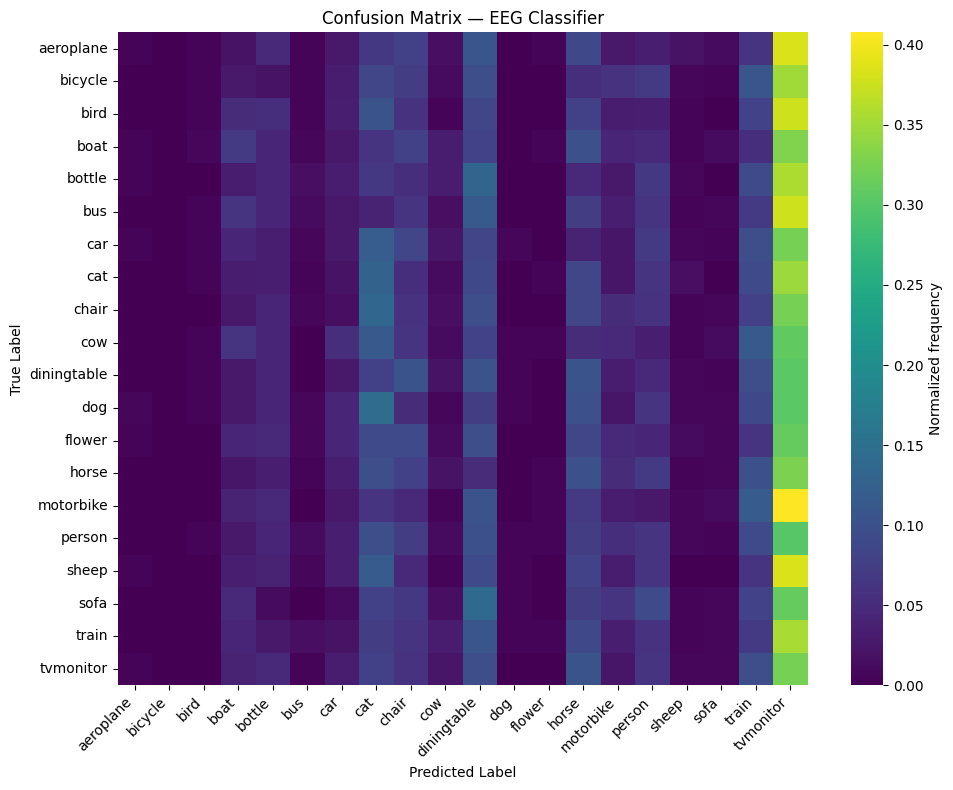


 Computing per-class accuracy...
       Category  Accuracy (%)
19    tvmonitor         32.31
7           cat         12.69
10  diningtable         10.38
13        horse         10.00
18        train          6.92
3          boat          6.92
15       person          6.15
8         chair          5.77
4        bottle          4.23
14    motorbike          3.08
6           car          2.69
5           bus          1.15
9           cow          1.15
17         sofa          0.77
0     aeroplane          0.38
2          bird          0.38
11          dog          0.38
1       bicycle          0.00
12       flower          0.00
16        sheep          0.00

 Computing global metrics...
          Metric  Value (%)
0   Accuracy (%)   5.269231
1  Precision (%)   5.518378
2     Recall (%)   5.269231
3   F1-score (%)   3.747789

 Identifying most common confusion pairs...
        True  Predicted  Count
0  motorbike  tvmonitor    106
1  aeroplane  tvmonitor    100
2      sheep  tvmonitor    1

In [42]:
print("\n Running full evaluation on test set...")
cm, per_class_df, summary_df, confusion_pairs_df = evaluate_model(
    model,
    loaders["test"],
    device=device,
    save_dir="results/"     # saves LaTeX + CSV tables
)

In [43]:
# ===== New Cell: Export evaluation results =====

per_class_df.to_csv("results/per_class_accuracy.csv", index=False)
summary_df.to_csv("results/global_metrics.csv", index=False)
confusion_pairs_df.to_csv("results/top_confusions.csv", index=False)

print("Results exported to results/ folder.")

Results exported to results/ folder.


# Improved Model

## Setup

In [9]:
subjects = sorted(index_df["subject"].unique())
subj2idx = {s: i for i, s in enumerate(subjects)}
print("Subjects + indices:", subj2idx)

Subjects + indices: {'sub-02': 0, 'sub-03': 1, 'sub-05': 2, 'sub-09': 3, 'sub-14': 4, 'sub-15': 5, 'sub-17': 6, 'sub-19': 7, 'sub-20': 8, 'sub-23': 9, 'sub-24': 10, 'sub-28': 11, 'sub-29': 12}


In [10]:
if config['model_to_use'] == "Multihead":
    model_mh = MultiHeadEEGClassifier(...)
elif config['model_to_use'] == "Multiscale":
    model_mh = MultiScaleEEGTransformerMH(...)
elif config["model_to_use"] == "Conformer":
    model_mh = ConformerMultiScaleEEG(
        num_channels   = config["num_channels"],
        num_classes    = config["num_classes"],
        n_subjects     = len(subj2idx),
        hidden_dim     = config["hidden_dim"],      
        transformer_dim= config["transformer_dim"], 
        n_layers       = config["n_layers"],        
        n_heads        = config["n_heads"],         
        ff_mult        = config["ff_mult"],
        dropout        = config["dropout"],
    )
model_mh = model_mh.to(device)


num_channels = config['num_channels'],
num_classes = config['num_classes'],
hidden_dim = config['hidden_dim'],          
transformer_dim = config['transformer_dim'],    
n_layers = config['n_layers'],
n_heads = config['n_heads'],
ff_mult = config['ff_mult'],
dropout = config['dropout']

In [11]:
print(f"{config['model_to_use']} model parameters:",
      sum(p.numel() for p in model_mh.parameters() if p.requires_grad))

# Torchinfo summary – we must pass BOTH x and subj_idx as input_data
dummy_x = torch.randn(1, 122, 500).to(device)   # [B, C, T]
dummy_subj = torch.tensor([0], dtype=torch.long).to(device)

summary(
    model_mh,
    input_data=(dummy_x, dummy_subj),
    depth=4,
    col_names=["kernel_size", "output_size", "num_params"],
    verbose=0
)

Conformer model parameters: 28057191


Layer (type:depth-idx)                                  Kernel Shape              Output Shape              Param #
ConformerMultiScaleEEG                                  --                        [1, 20]                   --
├─MultiScaleConvBlock: 1-1                              --                        [1, 250, 384]             --
│    └─Sequential: 2-1                                  --                        [1, 85, 500]              --
│    │    └─Conv1d: 3-1                                 [7]                       [1, 85, 500]              72,590
│    │    └─BatchNorm1d: 3-2                            --                        [1, 85, 500]              170
│    │    └─GELU: 3-3                                   --                        [1, 85, 500]              --
│    └─Sequential: 2-2                                  --                        [1, 85, 500]              --
│    │    └─Conv1d: 3-4                                 [15]                      [1, 85, 500]        

In [12]:
optimizer = optim.AdamW(
    model_mh.parameters(),
    lr=config['lr'],
    weight_decay=config['weight_decay'],
    betas=(0.9, 0.98),
)

scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config["num_epochs"],
    eta_min=1e-5
)


criterion = nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])

## Training

In [13]:
history_mh = train_multihead_model(
    model=model_mh,
    loaders=loaders,
    device=device,
    epochs=config["num_epochs"],
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    checkpoint_dir="checkpoints_multihead",
    max_grad_norm=config['max_grad_norm'],
    subj2idx=subj2idx,
)

[Train] Epoch 1/100:   0%|                                                                                                                                                                                 | 0/122 [00:00<?, ?it/s]

[Train] Epoch 1/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:24<00:00,  1.44it/s]


Epoch 01 | Train loss=3.1227 acc=4.86% | Val loss=3.1020 acc=4.98%
New best model at epoch 1 (val acc=4.98%)


[Train] Epoch 2/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.52it/s]


Epoch 02 | Train loss=3.0636 acc=4.49% | Val loss=3.0621 acc=5.17%
New best model at epoch 2 (val acc=5.17%)


[Train] Epoch 3/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 03 | Train loss=3.0463 acc=4.57% | Val loss=3.0356 acc=5.08%


[Train] Epoch 4/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.52it/s]


Epoch 04 | Train loss=3.0420 acc=4.66% | Val loss=3.0394 acc=5.15%


[Train] Epoch 5/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 05 | Train loss=3.0309 acc=4.97% | Val loss=3.0250 acc=5.27%
New best model at epoch 5 (val acc=5.27%)


[Train] Epoch 6/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 06 | Train loss=3.0244 acc=5.29% | Val loss=3.0306 acc=5.87%
New best model at epoch 6 (val acc=5.87%)


[Train] Epoch 7/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.52it/s]


Epoch 07 | Train loss=3.0119 acc=5.74% | Val loss=3.0245 acc=5.83%


[Train] Epoch 8/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.52it/s]


Epoch 08 | Train loss=3.0020 acc=6.32% | Val loss=3.0377 acc=6.08%
New best model at epoch 8 (val acc=6.08%)


[Train] Epoch 9/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 09 | Train loss=2.9880 acc=6.21% | Val loss=3.1139 acc=6.29%
New best model at epoch 9 (val acc=6.29%)


[Train] Epoch 10/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.52it/s]


Epoch 10 | Train loss=2.9728 acc=6.78% | Val loss=3.1337 acc=6.27%


[Train] Epoch 11/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.52it/s]


Epoch 11 | Train loss=2.9606 acc=7.48% | Val loss=3.0768 acc=6.08%


[Train] Epoch 12/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 12 | Train loss=2.9502 acc=7.53% | Val loss=3.1740 acc=6.81%
New best model at epoch 12 (val acc=6.81%)


[Train] Epoch 13/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.52it/s]


Epoch 13 | Train loss=2.9348 acc=7.90% | Val loss=3.2164 acc=5.87%


[Train] Epoch 14/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 14 | Train loss=2.9225 acc=8.17% | Val loss=3.2367 acc=5.94%


[Train] Epoch 15/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 15 | Train loss=2.9024 acc=8.63% | Val loss=3.2169 acc=5.77%


[Train] Epoch 16/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 16 | Train loss=2.8874 acc=8.63% | Val loss=3.2496 acc=6.00%


[Train] Epoch 17/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.52it/s]


Epoch 17 | Train loss=2.8739 acc=9.19% | Val loss=3.1725 acc=5.60%


[Train] Epoch 18/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.52it/s]


Epoch 18 | Train loss=2.8524 acc=9.99% | Val loss=3.2915 acc=6.19%


[Train] Epoch 19/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 19 | Train loss=2.8325 acc=10.47% | Val loss=3.3281 acc=6.42%


[Train] Epoch 20/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 20 | Train loss=2.8187 acc=10.74% | Val loss=3.3520 acc=6.08%


[Train] Epoch 21/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 21 | Train loss=2.7958 acc=11.53% | Val loss=3.6213 acc=6.17%


[Train] Epoch 22/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 22 | Train loss=2.7768 acc=11.72% | Val loss=3.4163 acc=5.73%


[Train] Epoch 23/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 23 | Train loss=2.7614 acc=11.77% | Val loss=3.9245 acc=6.37%


[Train] Epoch 24/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 24 | Train loss=2.7422 acc=12.71% | Val loss=3.5944 acc=6.17%


[Train] Epoch 25/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 25 | Train loss=2.7288 acc=12.94% | Val loss=3.5722 acc=6.44%


[Train] Epoch 26/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 26 | Train loss=2.7121 acc=13.22% | Val loss=4.1328 acc=5.60%


[Train] Epoch 27/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 27 | Train loss=2.6853 acc=14.40% | Val loss=4.1013 acc=5.96%


[Train] Epoch 28/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.52it/s]


Epoch 28 | Train loss=2.6755 acc=14.57% | Val loss=3.7903 acc=6.65%


[Train] Epoch 29/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 29 | Train loss=2.6592 acc=14.42% | Val loss=3.9796 acc=6.50%


[Train] Epoch 30/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 30 | Train loss=2.6417 acc=14.95% | Val loss=3.6902 acc=6.42%


[Train] Epoch 31/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.52it/s]


Epoch 31 | Train loss=2.6149 acc=16.10% | Val loss=3.6767 acc=6.56%


[Train] Epoch 32/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.52it/s]


Epoch 32 | Train loss=2.6144 acc=15.73% | Val loss=4.2585 acc=6.35%


[Train] Epoch 33/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 33 | Train loss=2.5871 acc=16.90% | Val loss=3.8227 acc=6.23%


[Train] Epoch 34/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.52it/s]


Epoch 34 | Train loss=2.5689 acc=17.26% | Val loss=4.1407 acc=6.17%


[Train] Epoch 35/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.52it/s]


Epoch 35 | Train loss=2.5581 acc=17.81% | Val loss=4.0333 acc=6.44%


[Train] Epoch 36/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 36 | Train loss=2.5394 acc=18.21% | Val loss=3.8990 acc=7.04%
New best model at epoch 36 (val acc=7.04%)


[Train] Epoch 37/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.52it/s]


Epoch 37 | Train loss=2.5224 acc=18.37% | Val loss=4.4943 acc=6.31%


[Train] Epoch 38/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 38 | Train loss=2.5077 acc=19.53% | Val loss=4.1357 acc=6.15%


[Train] Epoch 39/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 39 | Train loss=2.4886 acc=19.93% | Val loss=3.9321 acc=6.27%


[Train] Epoch 40/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 40 | Train loss=2.4755 acc=20.19% | Val loss=4.0197 acc=6.52%


[Train] Epoch 41/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 41 | Train loss=2.4557 acc=20.46% | Val loss=4.2549 acc=6.35%


[Train] Epoch 42/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.52it/s]


Epoch 42 | Train loss=2.4459 acc=21.07% | Val loss=3.9963 acc=6.67%


[Train] Epoch 43/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 43 | Train loss=2.4310 acc=21.56% | Val loss=3.9166 acc=6.12%


[Train] Epoch 44/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.52it/s]


Epoch 44 | Train loss=2.4164 acc=21.86% | Val loss=4.4114 acc=6.52%


[Train] Epoch 45/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 45 | Train loss=2.4030 acc=22.54% | Val loss=4.2798 acc=6.29%


[Train] Epoch 46/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 46 | Train loss=2.3846 acc=23.36% | Val loss=4.4058 acc=6.12%


[Train] Epoch 47/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.52it/s]


Epoch 47 | Train loss=2.3806 acc=23.56% | Val loss=4.0322 acc=6.06%


[Train] Epoch 48/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 48 | Train loss=2.3645 acc=23.58% | Val loss=4.1179 acc=6.48%


[Train] Epoch 49/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.52it/s]


Epoch 49 | Train loss=2.3451 acc=24.52% | Val loss=4.3342 acc=6.08%


[Train] Epoch 50/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 50 | Train loss=2.3363 acc=24.70% | Val loss=4.3438 acc=6.48%


[Train] Epoch 51/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 51 | Train loss=2.3272 acc=25.48% | Val loss=4.3567 acc=6.12%


[Train] Epoch 52/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 52 | Train loss=2.3110 acc=25.45% | Val loss=4.2804 acc=6.46%


[Train] Epoch 53/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 53 | Train loss=2.2923 acc=26.41% | Val loss=4.1587 acc=6.33%


[Train] Epoch 54/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 54 | Train loss=2.2813 acc=26.41% | Val loss=4.4018 acc=6.52%


[Train] Epoch 55/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 55 | Train loss=2.2683 acc=27.00% | Val loss=4.2729 acc=6.69%


[Train] Epoch 56/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.52it/s]


Epoch 56 | Train loss=2.2502 acc=27.99% | Val loss=4.3698 acc=6.92%


[Train] Epoch 57/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 57 | Train loss=2.2491 acc=28.05% | Val loss=4.3769 acc=6.08%


[Train] Epoch 58/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 58 | Train loss=2.2329 acc=28.60% | Val loss=4.4833 acc=6.54%


[Train] Epoch 59/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 59 | Train loss=2.2219 acc=28.84% | Val loss=4.4406 acc=6.75%


[Train] Epoch 60/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 60 | Train loss=2.2180 acc=28.74% | Val loss=4.4930 acc=6.35%


[Train] Epoch 61/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 61 | Train loss=2.2053 acc=29.29% | Val loss=4.5544 acc=6.21%


[Train] Epoch 62/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 62 | Train loss=2.1954 acc=29.49% | Val loss=4.5060 acc=6.44%


[Train] Epoch 63/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.52it/s]


Epoch 63 | Train loss=2.1755 acc=31.44% | Val loss=4.3380 acc=6.17%


[Train] Epoch 64/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 64 | Train loss=2.1713 acc=30.87% | Val loss=4.5104 acc=6.73%


[Train] Epoch 65/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.52it/s]


Epoch 65 | Train loss=2.1529 acc=32.24% | Val loss=4.4918 acc=6.35%


[Train] Epoch 66/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 66 | Train loss=2.1565 acc=31.49% | Val loss=4.4847 acc=6.73%


[Train] Epoch 67/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 67 | Train loss=2.1380 acc=32.51% | Val loss=4.5583 acc=6.83%


[Train] Epoch 68/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.52it/s]


Epoch 68 | Train loss=2.1245 acc=32.40% | Val loss=4.5253 acc=6.69%


[Train] Epoch 69/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 69 | Train loss=2.1218 acc=32.85% | Val loss=4.6277 acc=6.50%


[Train] Epoch 70/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 70 | Train loss=2.1042 acc=33.19% | Val loss=4.6854 acc=6.29%


[Train] Epoch 71/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.52it/s]


Epoch 71 | Train loss=2.1011 acc=33.92% | Val loss=4.6274 acc=6.35%


[Train] Epoch 72/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.52it/s]


Epoch 72 | Train loss=2.0925 acc=34.38% | Val loss=4.6249 acc=6.62%


[Train] Epoch 73/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 73 | Train loss=2.0781 acc=34.88% | Val loss=4.7772 acc=6.12%


[Train] Epoch 74/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 74 | Train loss=2.0780 acc=34.77% | Val loss=4.6234 acc=6.77%


[Train] Epoch 75/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 75 | Train loss=2.0572 acc=35.54% | Val loss=4.6598 acc=6.40%


[Train] Epoch 76/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.52it/s]


Epoch 76 | Train loss=2.0555 acc=35.58% | Val loss=4.7534 acc=6.67%


[Train] Epoch 77/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 77 | Train loss=2.0338 acc=36.25% | Val loss=4.7657 acc=6.62%


[Train] Epoch 78/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.52it/s]


Epoch 78 | Train loss=2.0375 acc=36.58% | Val loss=4.7178 acc=6.40%


[Train] Epoch 79/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.52it/s]


Epoch 79 | Train loss=2.0216 acc=36.97% | Val loss=4.7061 acc=6.63%


[Train] Epoch 80/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.52it/s]


Epoch 80 | Train loss=2.0183 acc=37.17% | Val loss=4.7457 acc=6.54%


[Train] Epoch 81/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.52it/s]


Epoch 81 | Train loss=2.0195 acc=37.26% | Val loss=4.7149 acc=6.60%


[Train] Epoch 82/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 82 | Train loss=2.0196 acc=36.64% | Val loss=4.6725 acc=6.92%


[Train] Epoch 83/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 83 | Train loss=2.0143 acc=37.32% | Val loss=4.7315 acc=6.37%


[Train] Epoch 84/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 84 | Train loss=2.0095 acc=37.79% | Val loss=4.7237 acc=6.58%


[Train] Epoch 85/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.52it/s]


Epoch 85 | Train loss=1.9939 acc=38.44% | Val loss=4.6961 acc=6.81%


[Train] Epoch 86/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 86 | Train loss=1.9817 acc=39.04% | Val loss=4.7113 acc=6.48%


[Train] Epoch 87/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 87 | Train loss=1.9830 acc=38.69% | Val loss=4.7276 acc=6.73%


[Train] Epoch 88/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 88 | Train loss=1.9734 acc=39.26% | Val loss=4.7250 acc=6.60%


[Train] Epoch 89/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 89 | Train loss=1.9662 acc=39.71% | Val loss=4.7859 acc=6.71%


[Train] Epoch 90/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 90 | Train loss=1.9690 acc=39.25% | Val loss=4.7299 acc=6.81%


[Train] Epoch 91/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:21<00:00,  1.50it/s]


Epoch 91 | Train loss=1.9610 acc=39.63% | Val loss=4.7823 acc=6.67%


[Train] Epoch 92/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:21<00:00,  1.50it/s]


Epoch 92 | Train loss=1.9625 acc=38.99% | Val loss=4.7448 acc=6.56%


[Train] Epoch 93/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:21<00:00,  1.50it/s]


Epoch 93 | Train loss=1.9513 acc=39.81% | Val loss=4.7456 acc=6.69%


[Train] Epoch 94/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:21<00:00,  1.50it/s]


Epoch 94 | Train loss=1.9535 acc=39.94% | Val loss=4.7616 acc=6.62%


[Train] Epoch 95/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 95 | Train loss=1.9547 acc=39.87% | Val loss=4.7454 acc=6.62%


[Train] Epoch 96/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:21<00:00,  1.50it/s]


Epoch 96 | Train loss=1.9452 acc=40.66% | Val loss=4.7952 acc=6.69%


[Train] Epoch 97/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:21<00:00,  1.50it/s]


Epoch 97 | Train loss=1.9359 acc=40.70% | Val loss=4.7637 acc=6.69%


[Train] Epoch 98/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:21<00:00,  1.50it/s]


Epoch 98 | Train loss=1.9425 acc=40.77% | Val loss=4.7642 acc=6.83%


[Train] Epoch 99/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:21<00:00,  1.50it/s]


Epoch 99 | Train loss=1.9409 acc=40.67% | Val loss=4.7481 acc=6.79%


[Train] Epoch 100/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [01:20<00:00,  1.51it/s]


Epoch 100 | Train loss=1.9426 acc=40.48% | Val loss=4.7458 acc=6.69%

Training complete. Best epoch=36 val acc=7.04%


## Evaluation

In [14]:
model_mh.load_state_dict(history_mh["best_state_dict"])
print(f"Loaded best multi-head model from epoch {history_mh['best_epoch']} "
      f"(val acc={history_mh['best_val_acc']*100:.2f}%).")

Loaded best multi-head model from epoch 36 (val acc=7.04%).


In [15]:
# %%
def collect_predictions_multihead(model, loader, device, subj2idx):
    """
    Run model over a loader and collect predictions + labels for multi-head model.
    model(x, subj_idx) -> logits
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for xb, meta in tqdm(loader, desc="Evaluating (multi-head)"):
            x = xb.to(device)
            y = meta["class_id"].to(device)

            subj_idx = torch.tensor(
                [subj2idx[s] for s in meta["subject"]],
                dtype=torch.long,
                device=device,
            )

            logits = model(x, subj_idx)
            preds = logits.argmax(dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    return all_preds, all_labels

# Collect predictions on test set
mh_preds, mh_labels = collect_predictions_multihead(
    model_mh, loaders["test"], device, subj2idx
)
print("Collected multi-head predictions:", len(mh_preds))

Evaluating (multi-head): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:08<00:00,  5.00it/s]

Collected multi-head predictions: 5200


In [16]:
# %%
test_acc_mh = accuracy_score(mh_labels, mh_preds)
print(f"Multi-head Test Accuracy: {test_acc_mh*100:.2f}%")

Multi-head Test Accuracy: 6.62%


Confusion matrix saved at results/Conformer_Finetune_Multihead/confusion_matrix.png


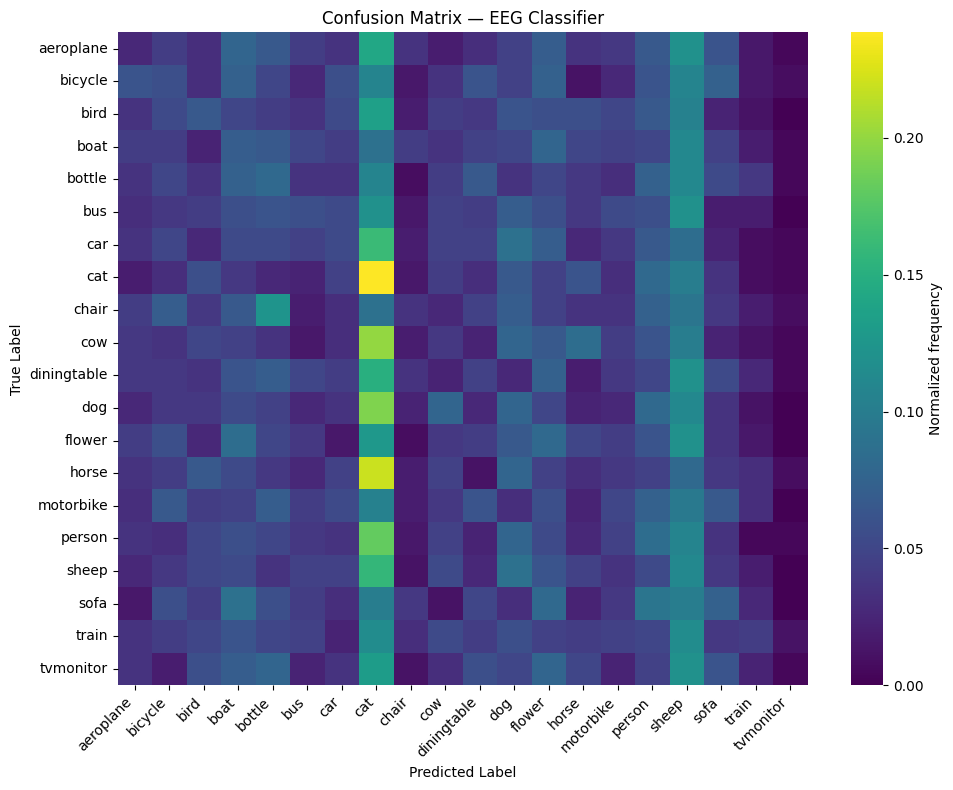

   Category  Accuracy (%)
7       cat         23.85
16    sheep         11.15
15   person          8.46
4    bottle          8.08
12   flower          8.08
          Metric  Value (%)
0   Accuracy (%)   6.615385
1  Precision (%)   6.592777
2     Recall (%)   6.615385
3   F1-score (%)   6.083136
[('horse', 'cat', np.int64(57)), ('cow', 'cat', np.int64(52)), ('dog', 'cat', np.int64(50)), ('person', 'cat', np.int64(47)), ('car', 'cat', np.int64(42)), ('sheep', 'cat', np.int64(41)), ('diningtable', 'cat', np.int64(39)), ('aeroplane', 'cat', np.int64(37)), ('bird', 'cat', np.int64(35)), ('tvmonitor', 'cat', np.int64(34))]


In [17]:
# Confusion matrix
cm_mh = plot_confusion_matrix(
    mh_labels,
    mh_preds,
    normalize=True,
    save_path=f"{config['results_path']}/confusion_matrix.png"
)

# Per-class accuracy
per_class_df_mh = compute_per_class_accuracy(mh_labels, mh_preds)
print(per_class_df_mh.head())

# Global metrics
metrics_dict_mh = compute_global_metrics(mh_labels, mh_preds)
summary_df_mh = metrics_to_dataframe(metrics_dict_mh)
print(summary_df_mh)

# Top confusing pairs
confusion_pairs_df_mh = top_confusion_pairs(mh_labels, mh_preds, top_k=10)
print(confusion_pairs_df_mh)

In [18]:
per_class_df_mh.to_csv(save_dir / "per_class_accuracy.csv", index=False)
summary_df_mh.to_csv(save_dir / "global_metrics.csv", index=False)
# Top confusion pairs (list of tuples)
confusion_pairs_mh = top_confusion_pairs(mh_labels, mh_preds, top_k=10)

# Convert to DataFrame
confusion_pairs_df_mh = pd.DataFrame(
    confusion_pairs_mh,
    columns=["True Label", "Predicted Label", "Count"]
)

print(confusion_pairs_df_mh)

# Save
confusion_pairs_df_mh.to_csv(save_dir / "top_confusions.csv", index=False)

with open(save_dir / "per_class_accuracy.tex", "w") as f:
    f.write(per_class_df_mh.to_latex(index=False, float_format="%.2f"))

with open(save_dir / "global_metrics.tex", "w") as f:
    f.write(summary_df_mh.to_latex(index=False, float_format="%.2f"))

print("Multi-head evaluation tables saved in results_multihead/")

    True Label Predicted Label  Count
0        horse             cat     57
1          cow             cat     52
2          dog             cat     50
3       person             cat     47
4          car             cat     42
5        sheep             cat     41
6  diningtable             cat     39
7    aeroplane             cat     37
8         bird             cat     35
9    tvmonitor             cat     34
Multi-head evaluation tables saved in results_multihead/


# Implement best model for CLIP layer

In [20]:
# Make sure best weights from training are loaded
model_mh.load_state_dict(history_mh["best_state_dict"])
model_mh.eval()
model_mh.to(device)

export_all_splits_multihead(
    model_mh, loaders, device, subj2idx,
    save_dir=config['results_path']
)

print("\nEEG embeddings saved in:", config['results_path'])


=== Exporting split: train ===


Collected 15600 embeddings, dim=384
Saved embeddings to: results/Conformer_Finetune_Multihead/multihead_train_embeddings.npy
Saved metadata  to: results/Conformer_Finetune_Multihead/multihead_train_meta.csv
Shape: embeddings=(15600, 384), rows=15600

=== Exporting split: val ===
Collected 5200 embeddings, dim=384
Saved embeddings to: results/Conformer_Finetune_Multihead/multihead_val_embeddings.npy
Saved metadata  to: results/Conformer_Finetune_Multihead/multihead_val_meta.csv
Shape: embeddings=(5200, 384), rows=5200

=== Exporting split: test ===
Collected 5200 embeddings, dim=384
Saved embeddings to: results/Conformer_Finetune_Multihead/multihead_test_embeddings.npy
Saved metadata  to: results/Conformer_Finetune_Multihead/multihead_test_meta.csv
Shape: embeddings=(5200, 384), rows=5200

EEG embeddings saved in: results/Conformer_Finetune_Multihead
